<a href="https://colab.research.google.com/github/thanhtruong1712/DAMH_LTSSUD/blob/main/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Đồ án môn học "Lập trình song song ứng dụng"

# Xác định loại bệnh thực vật bằng phương pháp trích xuất dữ liệu và mô hình XGBoost.

## Giảng viên: Phạm Trọng Nghĩa

### Nhóm 14:
- 1712771 - Bùi Thái Tấn Thành
- 1712770 - Trương Thị Lệ Thanh


## Liên kết
- Github: https://github.com/thanhtruong1712/DAMH_LTSSUD
- Drive: https://drive.google.com/drive/folders/1rGZJJ5qUvcued9Zhqks27rpUL7wpIGpe?fbclid=IwAR0hKewhUqeb95jxwUCCh9ffm9f2czTxDsak-Ev9cbTBDPurizT1G7kfVzE
- [File bổ sung](https://colab.research.google.com/drive/16G9xGGcm6y4DFG015D_bRmTtzy8Aj_GN?usp=sharing): chứa các hàm tuần tự, độ chính xác và thời gian của chúng.

---

# **Import và load data**

In [ ]:
!gdown 1yOfcfEkLaHJjtk6xDprIMZ1TXbdnR4xx
!unzip -q /content/plant-pathology-2020-fgvc7.zip

!git clone https://github.com/thanhtruong1712/DAMH_LTSSUD.git

# thư viện đọc file phân tích thời gian chạy
from pstats import Stats

Downloading...
From: https://drive.google.com/uc?id=1yOfcfEkLaHJjtk6xDprIMZ1TXbdnR4xx
To: /content/plant-pathology-2020-fgvc7.zip
100% 817M/817M [00:08<00:00, 92.8MB/s]
Cloning into 'DAMH_LTSSUD'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 85 (delta 23), reused 48 (delta 7), pack-reused 0
Unpacking objects: 100% (85/85), 2.03 MiB | 5.85 MiB/s, done.


In [ ]:
!pip install -U xgboost==1.5.1 numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.5/173.5 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 110.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 17.6 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.1
    Uninstalling llvmlite-0.39.1:
      Successfully uninstalled llvmlite-0.39.1
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.7.5
    Uninstalling xgboost-1.7.5:
      Successfully uninstalled xgboost-1.7.5
  Attempting uninstall: numba
    Found existing installation: numba 0.56.4
    Uninstalling numba-0.56.4:
      Successfully uninstalled numba-0.56.4


# **1. Mô tả ứng dụng**

- **Xác định loại bệnh thực vật bằng phương pháp trích xuất dữ liệu và mô hình XGBoost**
	- Input: 
	 - một ảnh RGB hoặc 1 tập ảnh
	 - một mô hình XGBoost đã train
	- Output: `healthy`	`multiple_diseases`	`rust`	`scab`
	- Ý nghĩa của ứng dụng trong thực tế:
		- tránh các chẩn đoán sai dẫn đến tăng chi phí, hại môi trường khi sự dụng sai thuốc, hóa chất cho cây trồng
		- chẩn đoán hiện tại dựa trên con người: tốn thời gian, tốn kém và không mang lại hiệu quả 
		- ứng dụng thường được sử dụng trên số lượng lớn cây (theo vườn, nông trại)


![](https://github.com/thanhtruong1712/DAMH_LTSSUD/blob/main/notebook/img_report/Frame_1.png?raw=true)

- Lý do cần tăng tốc ứng dụng:
	- Có nhiều ý nghĩa thực tế, có thể áp dụng cho đa dạng loại thực vật; riêng trích xuất dữ liệu có thể áp dụng cho các bài toán dạng ảnh.
	- Ứng dụng này sẽ chạy chậm nếu cài đặt tuần tự
	- Mô hình XGBoost có thể song song hóa và tối ưu hóa.
	





- Khả năng song song hóa
	- Các bước tiền xử lý có thể song song hóa.
	- Trích xuất dữ liệu có thể song song hóa
	- Các cây độc lập với nhau

**Lưu đồ quá trình huấn luyện mô hình XGBoost**
![](https://github.com/thanhtruong1712/DAMH_LTSSUD/blob/main/notebook/img_report/XGboost_model.png?raw=true)

---

# 2. Cài đặt tuần tự

## 2.1. Thiết kế
Tóm tắt các bước:
- Tiền xử lý: chuyển xám, đạo hàm, nén ảnh v.v..
- Trích xuất: color histogram và hue moments
- Lấy trọng số từ mô hình XGBoost và thực hiện tính toán

![](https://github.com/thanhtruong1712/DAMH_LTSSUD/blob/main/notebook/img_report/flow.png?raw=true)

####**2.1.0**. **Tại sao cần tiền xử lý & trích xuất:**

![](https://github.com/thanhtruong1712/DAMH_LTSSUD/blob/main/notebook/img_report/Frame_1.png?raw=true)

**Nhìn lại các lớp:**

**Nhận xét:**
- Ở đây chúng ta có thể thấy rằng ở class rust thì lá thường sẽ có màu các đốm màu vàng và class scab thì thường sẽ có các vết màu đen.
- Từ đó vấn đề về màu sắc là một thuộc tính rõ ràng để chúng ta trích xuất dữ liệu cho các class này
- Vậy nên nhóm quyết định chọn 2 figure chính cho model thứ nhất này là color histogram và hue moments hai figure liên quan đến màu sắc.

**Vấn đề gặp phải:**
- Background của các ảnh chứa quá nhiều chi tiết về màu sắc thừa cần phải loại bỏ những chi tiết này để mô hình có thể dự đoán tốt hơn.

####**2.1.1**. **Tiền xử lý**






**Sử dụng đạo hàm ảnh bằng phương pháp candy**
- Nhóm không tuần tự mà sử dụng openCV do sai số khi cài đặt cao.


**Nén ảnh:** Sử dụng phương pháp nén ảnh với threshold
- Hàm dùng để nén ảnh với threshold là ratio sẽ trả ra kết quả là ảnh với block tương ứng với zip x zip và nếu block nào không đủ pixel yêu cầu thì là 0 còn ngược lại thì là 1
    >
    ![](https://github.com/thanhtruong1712/DAMH_LTSSUD/blob/main/notebook/img_report/1.png?raw=true)







**Lấp khuyết:** liên kết các ô xung quanh để lấp khuyết ảnh
- Hàm dùng để liên kết các ô xung quanh để lấp khuyết sẽ trả ra kết quả là một ma trận mask (cách lặp tương tự hàm `nén`)

![](https://github.com/thanhtruong1712/DAMH_LTSSUD/blob/main/notebook/img_report/join2.png?raw=true)
 

####**2.1.2**. **Trích xuất dữ liệu**

Trích xuất dữ liệu từ dạng ảnh sang dạng số

**Color histogram**: thống kê số lần xuất hiện các mức sáng trong ảnh với bins=8, phạm vi [0,255] cho mỗi kênh màu

![](https://github.com/thanhtruong1712/DAMH_LTSSUD/blob/main/notebook/img_report/hist.png?raw=true)



[**Hue moments**](https://en.wikipedia.org/wiki/Image_moment): 
- 7 giá trị với 1-6 là đối xứng phản xạ, 7 là phản xạ phản đối xứng 
- Các giá trị này được chứng minh là bất biến đối với tỷ lệ hình ảnh, phép quay và độ phản xạ ngoại trừ giá trị thứ bảy, có dấu hiệu bị thay đổi do phản xạ. Sự bất biến này được chứng minh với giả thiết về độ phân giải ảnh vô hạn. Trong trường hợp ảnh raster, các bất biến Hu được tính toán cho ảnh gốc và ảnh đã biến đổi có một chút khác biệt. ([OpenCV](https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html?highlight=cvmatchshapes#humoments))
- **Các bước:**
    - Tính Raw moments:

    ![](https://wikimedia.org/api/rest_v1/media/math/render/svg/66e11e03b979350e397c09cae989dbe0863bef13)

    - Central moments:

    ![](https://github.com/thanhtruong1712/DAMH_LTSSUD/blob/main/notebook/img_report/central_moments.png?raw=true)

    - Moment invariants: Scale invariants

    ![](https://wikimedia.org/api/rest_v1/media/math/render/svg/dffd35aa5fcf59a18ddcfda9206fa890ce525bf8)

    - Rotation invariants (7 giá trị output - Hu Moments)

    ![](https://github.com/thanhtruong1712/DAMH_LTSSUD/blob/main/notebook/img_report/hu.png?raw=true)


**Output:** mảng 519 giá trị gồm 512 giá trị color histogram, 7 giá trị hue moments

####**2.1.3**. **Dự đoán từ dữ liệu đã được trích xuất và mô hình XGBoost đã train**


Kiến trúc tổng quát của **XGBoost** ![](https://github.com/thanhtruong1712/DAMH_LTSSUD/blob/main/notebook/img_report/xgboost.png?raw=true) 

- Đọc mô hình:
    - Mở và phân tích cú pháp json tập tin siêu tham số mô hình.
    - Truy xuất từ điển thành phần chứa các siêu tham số, lấy ra các tham số:
        - n_estimators: số lượng cây quyết định thành phần của mô hình.
        - n_classes: số phân lớp huấn luyện.
        - max_depth: độ sâu tối đa.
    - Xác định số nút tối đa theo độ sâu tối đa =
    1 + 2 + 2^2 + ... + 2^6
    - Tạo mảng biểu diễn cây quyết định và đọc thông tin cây.
- Dự đoán:
    - Tạo mảng n_classes phần tử, phần tử i thể hiện xác suất thuộc về phân lớp i.
    - Duyệt cây: kết quả duyệt cây i tính tổng tích lũy cho phần tử  i % n_classes

**Ví dụ thông tin mô hình lưu ở dạng json**

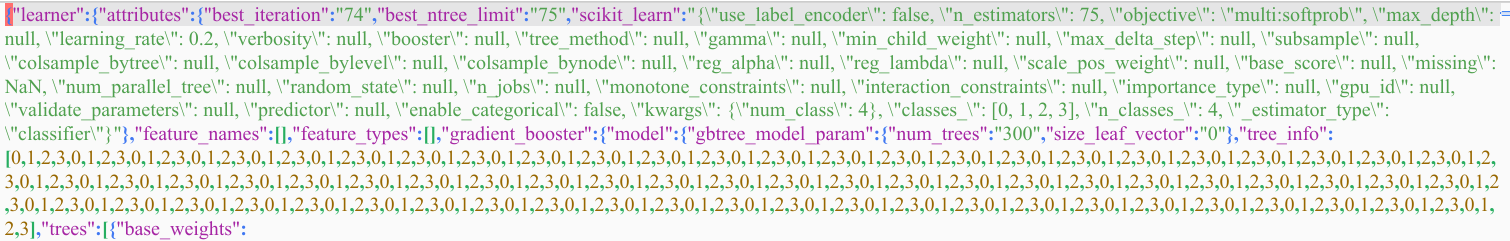

**Ví dụ biểu diễn cấu trúc cây lưu dạng json**

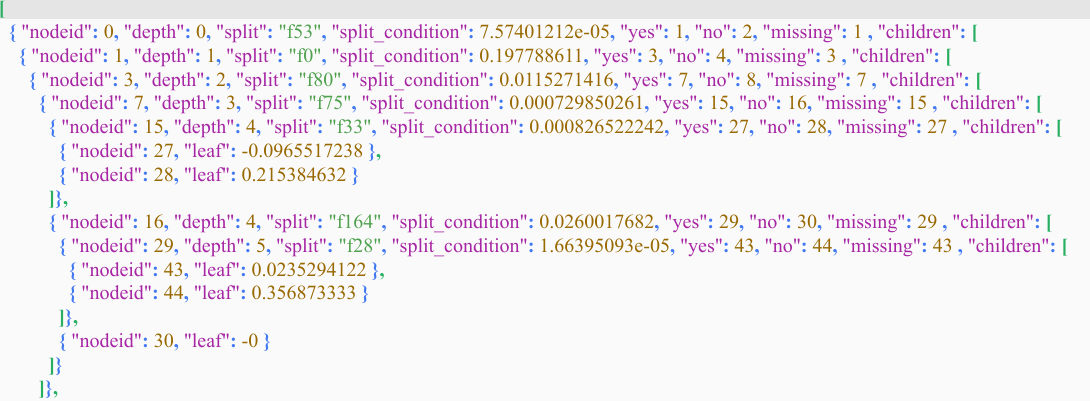

**Ví dụ cây quyết định và biểu diễn mảng**

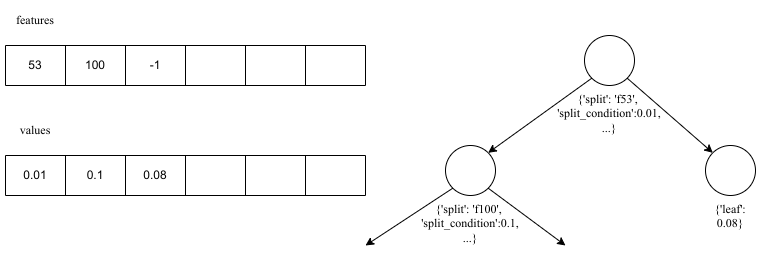

## 2.2. Đánh giá

- [Ảnh đầu vào](https://github.com/thanhtruong1712/DAMH_LTSSUD/blob/main/test/Test_4.jpg?raw=true) kích thước (1365, 2048, 3) có nhãn là `rust`
- [Tập test đầu vào](https://drive.google.com/drive/folders/1rGZJJ5qUvcued9Zhqks27rpUL7wpIGpe?usp=drive_link) gồm 1821 ảnh
- Thời gian chạy được đo bằng `timeit.default_timer()` và `pstats.Stats`

In [ ]:
!python -m cProfile -o xgb.prof /content/DAMH_LTSSUD/code/test.py \
/content/DAMH_LTSSUD/data/xgb_hyperparams.json /content/DAMH_LTSSUD/data/xgb_tree.json -i /content/images/Test_4.jpg

/usr/local/lib/python3.10/dist-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
Baseline: opencv & xgboost library
Feature extraction: 2248.5105991363525ms
XGBoost prediction: 1127.876043ms 

Sequential implementation
Feature extraction: 7315.017223358154ms
XGBoost prediction: 1180.276155ms 


features mean error: 0.007199254054101792
error with xgboost library classifier: 1


In [ ]:
# khởi tạo đối tượng đọc file phân tích thời gian chạy
stats = Stats('/content/xgb.prof')
# sắp xếp thời gian chạy tích lũy giảm dần, in thời gian chạy những hàm thuộc tập tin feature_extract.py
# https://docs.python.org/3/library/profile.html#instant-user-s-manual
stats.sort_stats('cumulative').print_stats('/content/DAMH_LTSSUD/code/feature_extract.py')

Sun Jun  4 10:28:22 2023    /content/xgb.prof

         10732874 function calls (10225407 primitive calls) in 14.602 seconds

   Ordered by: cumulative time
   List reduced from 11542 to 13 due to restriction <'/content/DAMH_LTSSUD/code/feature_extract.py'>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.021    0.021    7.315    7.315 /content/DAMH_LTSSUD/code/feature_extract.py:322(getFigureForImage2)
        1    0.000    0.000    5.893    5.893 /content/DAMH_LTSSUD/code/feature_extract.py:311(fd_hu_moments2)
        1    0.010    0.010    2.248    2.248 /content/DAMH_LTSSUD/code/feature_extract.py:374(getFigureForImage)
        1    0.000    0.000    1.202    1.202 /content/DAMH_LTSSUD/code/feature_extract.py:297(fd_histogram2)
        1    0.165    0.165    0.166    0.166 /content/DAMH_LTSSUD/code/feature_extract.py:218(cvMoments)
        4    0.123    0.031    0.123    0.031 /content/DAMH_LTSSUD/code/feature_extract.py:170(joinNeighborPixel)

**Nhận xét:**
- Độ chính xác khi cài đặt tuần tự cao, kết quả trên các ảnh: 97%.
- Thời gian chạy chậm hơn khi dùng thư viện rất nhiều.

**Lý do:**
- Nhóm cài đặt tuần tự không tốt bằng cách mà các thư viện hoạt động.


**Các hàm đã cài đặt tuần tự**

| Hàm | Sai số |Thời gian |Ghi chú |
|:--------:|:-----------:|:-----------:|:-----------:|
|rgb2gray  |  1.43e-06 |  413 ms |  | 
| GBR2HSV  | 0.025|65.1 ms|  Không sử dụng| 
| GaussianBlur  |  108.53 | 2.36 s |  Không sử dụng | 
| Histogram  | 0 | 343 ms|  | 
| huMoments  | 2.32e-23 | 2.27 s | | 
| duyệt cây  | |  46 ms|   | 
| zipImage  |  | 996 ms |   | 
| joinNeiboorPixel  |  | 767 ms |   | 


Trên đây là thời gian cụ thể của các một số hàm tuần tự nhóm đã cài đặt. Ngoài ra còn một số hàm tự cài đặt nhưng có sử dụng thư viện không được đề cập tới trong file này.

Riêng 2 hàm `GBR2HSV` và `GaussianBlur` nhóm không sử dụng do sai số lớn.

**Lựa chọn các hàm (chức năng) để song song:**
- RGB2GRAY: chuyển xám
- Histogram
- HueMoments
- zipImage: nén ảnh
- joinNeiboorPixel: lấp khuyết 
- Hàm kích hoạt softmax
- Duyệt cây 
- Song song các ảnh khi chạy trên tập ảnh.

# **3. Cài đặt song song lần 1**

## 3.1. Phân tích

Thực hiện song song hóa các hàm:
- Chuyển ảnh màu sang ảnh xám: mỗi pixel ảnh xám có thể được tính độc lập nên có thể song song để cải thiện thời gian chạy.
- Hàm kích hoạt softmax: song song theo từng dòng trên mảng 2 chiều biểu diễn theo mảng 1 chiều. Kết quả lưu vào mảng softmax truyền vào.
- Hàm duyệt cây: song song các đối tượng trên 1 cây.

## 3.2. Thiết kế

 **Chuyển xám**: mỗi pixel ảnh xám có thể được tính độc lập theo công thức `r*0.114 + g*0.587 + b*0.299`

 **Hàm Softmax:**

 $$a_i = \frac{\exp(z_i)}{\sum_{j=1}^C \exp(z_j)}, ~~ \forall i = 1, 2, \dots, C$$

- Với mỗi luồng song song i, nếu trong phạm vi mảng đầu vào arr thì thực hiện:
    1. tính e^arr[i]
    2. xác định dòng của phần tử và cộng kết quả trên vào ô đầu dòng.
    3. (1) / (2) sau khi những ô cùng dòng đã tính xong. 

**Hàm duyệt cây và dự đoán**
- Khởi tạo mảng lưu kết quả dự đoán, kích thước (n_classes, X.shape[0]) với giá trị 0.
    - n_classes: số phân lớp
    - X.shape[0]: số đối tượng
- Chuyển vị mảng đầu vào.
- Duyệt song song các đối tượng trên từng cây, mỗi luồng thực hiện duyệt trên 1 đối tượng, lưu kết quả vào mảng trên.
- Áp dụng hàm kích hoat softmax.
- Thay đổi kích thước mảng kết quả thành (X.shape[0], n_classes) và trả về.

## 3.3. Đánh giá

- Cách đưa input vào và cách đo thời gian tương tự cài đặt tuần tự

**Nhận xét song song lần 1**: 
- Độ chính xác cao: không có sai số khi dự đoán so với tuần tự
- Thời gian chạy thấp hơn: trích xuất giảm 2.3 lần; dự đoán giảm 1.2 lần 

---

# **4. Cài đặt song song lần 2**

## 4.1 Phân tích

Thực hiện song song hóa các hàm:
- Color histogram: song song hóa từng pixel, sau đó đếm lưu vào mảng (8,8,8) bằng `cuda.atomic.add` (chưa hoàn thiện)
- Hue Moments: song song hóa từng pixel theo [công thức](https://en.wikipedia.org/wiki/Image_moment) (chưa hoàn thiện)

- Hàm duyệt cây: duyệt song song các cây thành phần.

## 4.2 Thiết kế

Tại phiên bản song song v0, các cây được duyệt tuần tự

⇒ Phiên bản v1 thực hiện việc duyệt song song các cây thành phần sử dụng cuda stream.

## 4.3 Đánh giá
So sánh với phiên bản `song song hóa lần 1`

**Nháp**:
- xuất thời gian: 2
- xuất độ chính xác: 2

**Nhận xét song song và tối ưu lần 2**: 
- Độ chính xác cao: không có sai số khi dự đoán so với tuần tự
- Thời gian chạy thấp hơn lần trước : dự đoán giảm 1.3 lần

# **5. Cài đặt song song lần 3**

## 5.1 Phân tích:

Thực hiện song song hóa các hàm:
- Nén ảnh: Hàm dùng để nén ảnh với threshold là ratio sẽ trả ra kết quả là ảnh với block tương ứng với zip x zip và nếu block nào không đủ pixel yêu cầu thì là 0 còn ngược lại thì là 1  $\to$ song song các block
- Lấp khuyết: tương tự nén ảnh, ta sẽ độc lập các block
- Color histogram: song song hóa từng pixel, sau đó đếm lưu vào mảng (8,8,8) bằng `cuda.atomic.add`
- Hue Moments: song song hóa từng pixel theo [công thức](https://en.wikipedia.org/wiki/Image_moment)

## 5.2 Thiết kế

**Histogram:**
- duyệt độc lập từng pixel 
- khởi tạo mảng 0 size = (8,8,8)
- cộng dồn 1 tại x,y,z; sử dụng `cuda.atomic.add` tránh việc trùng bộ nhớ

**HueMoments:**
- Raw Moments: duyệt độc lập x, y tại mỗi i,j
- Các bước khác không cần song song hóa: do tính toán trực tiếp hoặc ít vòng lặp





## 5.3 Đánh giá

So sánh với phiên bản `song song hóa lần 2`

**Nhận xét song song và tối ưu lần 3**: 
- Độ chính xác cao: sai số 28/1821 ~ 1.5%
- Thời gian chạy cao hơn lần trước : trích xuất trên 1 ảnh tăng gấp 4, toàn tập nhanh hơn ~30s. 

**Lý do:**
- Nhóm cài đặt chưa tốt
- Tốn thời gian cho việc copy dữ liệu giữa host và device
- Có sử dụng cuda.atomic.add: tuần tự hóa giữa các thread

# **Tổng kết:**
 
 **Test_4**: (1365, 2048, 3)


|  | sequential | parallel_v0  | parallel_v1  |parallel_v2  |
|:--------:|:-----------:|:------------:|:------------:|:------------:|
|trích xuất    |  2933.65836 | 266.474723  | 266.474723  | 1384.9825859  |
| dự đoán     |  882.129669 | 1152.3268  | 608.254671  | 608.254671  |
| Tổng     |  3815.788029 | 1418.801523  | 874.729394 | 1992.833071  |

 
 **Tập test**: 1821 ảnh


|  | sequential | parallel_v0  | parallel_v1  |parallel_v2  |
|:--------:|:-----------:|:------------:|:------------:|:------------:|
|trích xuất    |  09:54 | 08:04  | 08:03  | 07:31  |
| dự đoán     |  1230.721235 | 979.421854  | 470.649958  | 470.649958  |
| Tổng     |  09:55 | 08:05  | 08:04 | 07:32  |

**Nhận xét:**
- Nhìn chung nhóm hoàn thiện tốt phần dự đoán bao gồm song song các ảnh.
- Phần lớn thời gian tập trung ở phần trích xuất do sử dụng thư viện nên không thể song song các ảnh.

# 6. Nhìn lại quá trình làm đồ án

---

# 7. Tài liệu tham khảo

- Nhập môn học máy: [BÀI TẬP THỰC HÀNH II ](https://drive.google.com/file/d/1U65IfdkizLD0pd1aQKp9xqVRnTj5bejR/view)
- [Image moment - Wiki](https://en.wikipedia.org/wiki/Image_moment)

- https://towardsdatascience.com/using-nmf-to-classify-companies-a77e176f276f
- https://github.com/jonasrothfuss/fishervector
- https://hal.inria.fr/hal-00779493/file/RR-8209.pdf
- [SIFT ( Scale-invariant feature transform) - Huấn luyện mô hình cho các bài toán phân loại](https://viblo.asia/p/sift-scale-invariant-feature-transform-huan-luyen-mo-hinh-cho-cac-bai-toan-phan-loai-924lJqJaZPM)
- https://xgboost.readthedocs.io/en/stable/
- https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663
- https://medium.com/analytics-vidhya/what-makes-xgboost-so-extreme-e1544a4433bb
- https://www.tensorflow.org/tutorials/load_data/images#using_tfdata_for_finer_control
- https://www.smartdraw.com/flowchart/flowchart-symbols.htm
- https://en.wikipedia.org/wiki/Image_moment#cite_note-%E2%80%9Chu-1
- [OpenCV RGB histogram calculation and drawing----calcHist() function, normalize() function](https://www.programmerall.com/article/5123272509/)

